References so far:

1. Use ScoreCAM: non-graident based heatmap explainer 
    
    Paper: https://arxiv.org/pdf/1910.01279
    
    Code: https://github.com/tabayashi0117/Score-CAM/blob/master/Score-CAM.ipynb

2. Explainable-CNN: https://github.com/tavanaei/ExplainableCNN/tree/master

    "This paper proposes a new explainable convolutional neural network (XCNN) which represents important and driving visual features of stimuli in an end-to-end model architecture. This network employs encoder-decoder neural networks in a CNN architecture to represent regions of interest in an image based on its category"
    
    Paper: https://arxiv.org/pdf/2007.06712

    The heatmap in this paper are generated using iNNvestigate: https://arxiv.org/pdf/1808.04260 (https://github.com/albermax/innvestigate?tab=readme-ov-file)


In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision import datasets
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
import pickle
import os
import matplotlib.image as img
from PIL import Image
import torchvision
from helpers import *
from evaluate import *

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys

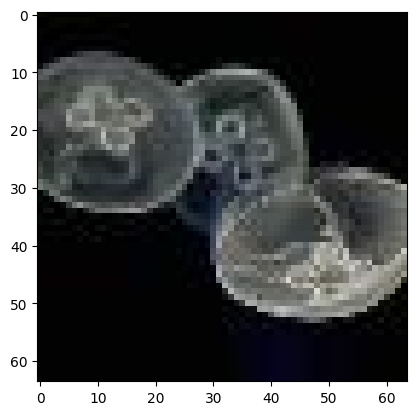

In [3]:
# -1151 for a cute cat
demo_index = 84
encoding = 'angle'
ansatz = 'basic'
filter_size = 2
x_original, x_quanv, y = get_data(encoding, ansatz, filter_size)

plt.imshow(x_original[demo_index])

Text(0.5, -0.35, 'Class 3')

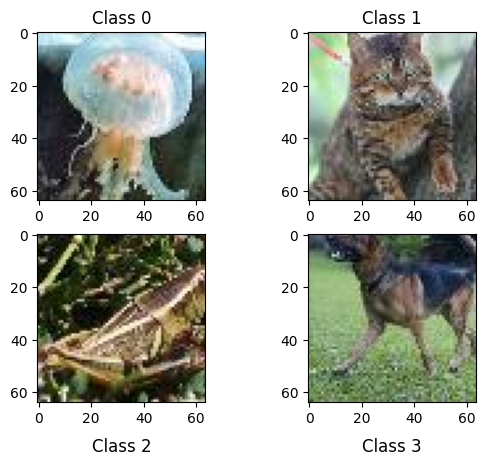

In [4]:
class_0 = np.where(y == 0)[0][0] # Jellyfish
class_1 = np.where(y == 1)[0][0] # CATTTTTT
class_2 = np.where(y == 2)[0][0] # Grasshopper
class_3 = np.where(y == 3)[0][0] # DOGGGGGG


f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_original[class_0])
axarr[0,0].set_title("Class 0")

axarr[0,1].imshow(x_original[class_1])
axarr[0,1].set_title("Class 1")

axarr[1,0].imshow(x_original[class_2])
axarr[1,0].set_title("Class 2",y = -0.35)

axarr[1,1].imshow(x_original[class_3])
axarr[1,1].set_title("Class 3", y = -0.35)

In [5]:
x_original[demo_index].shape, set(y)

((64, 64, 3), {np.int64(0), np.int64(1), np.int64(2), np.int64(3)})

# Heatmap from XCNN (loaded by torch) generated using iNNvestigate

In [6]:
device = torch.device('cpu')
model_name = './Models/Model_TinyImageNet_128.net'
net = torch.load(model_name, map_location=torch.device('cpu')).to(device)

In [7]:
from torchsummary import summary
print(net)

Model(
  (decoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (encoder): Sequential(
    (0): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
    (1): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Tanh()
  )
  (feature): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [8]:
heatmap_xcnn = get_xcnn_heatmap(x_original[demo_index])
heatmap_xcnn.shape

(64, 64, 1)

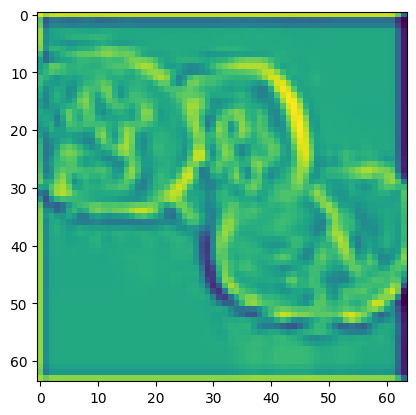

In [9]:

plt.imshow(heatmap_xcnn)
plt.show()

# Quanvolution filter

Quanvoluted images of the above image

for 2x2 filter, quanvolution would produce 4 channels

(32, 32, 4)


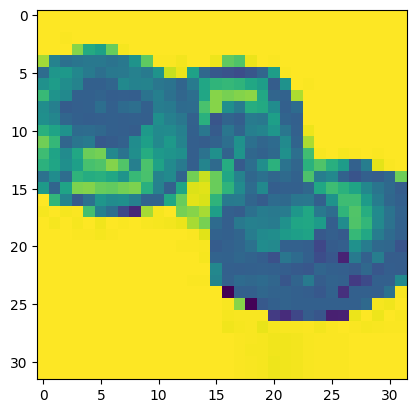

In [10]:
print(x_quanv[demo_index].shape)

plt.imshow(x_quanv[demo_index][:,:,0])
plt.show()

Original shape: (64, 64, 3)
Quanvoluted shape: (32, 32)
Quanvoluted shape: (32, 32)
Quanvoluted shape: (32, 32)
Quanvoluted shape: (32, 32)
Original shape: (64, 64, 3)
Quanvoluted shape: (32, 32)
Quanvoluted shape: (32, 32)
Quanvoluted shape: (32, 32)
Quanvoluted shape: (32, 32)
Original shape: (64, 64, 3)
Quanvoluted shape: (32, 32)
Quanvoluted shape: (32, 32)
Quanvoluted shape: (32, 32)
Quanvoluted shape: (32, 32)
Original shape: (64, 64, 3)
Quanvoluted shape: (32, 32)
Quanvoluted shape: (32, 32)
Quanvoluted shape: (32, 32)
Quanvoluted shape: (32, 32)


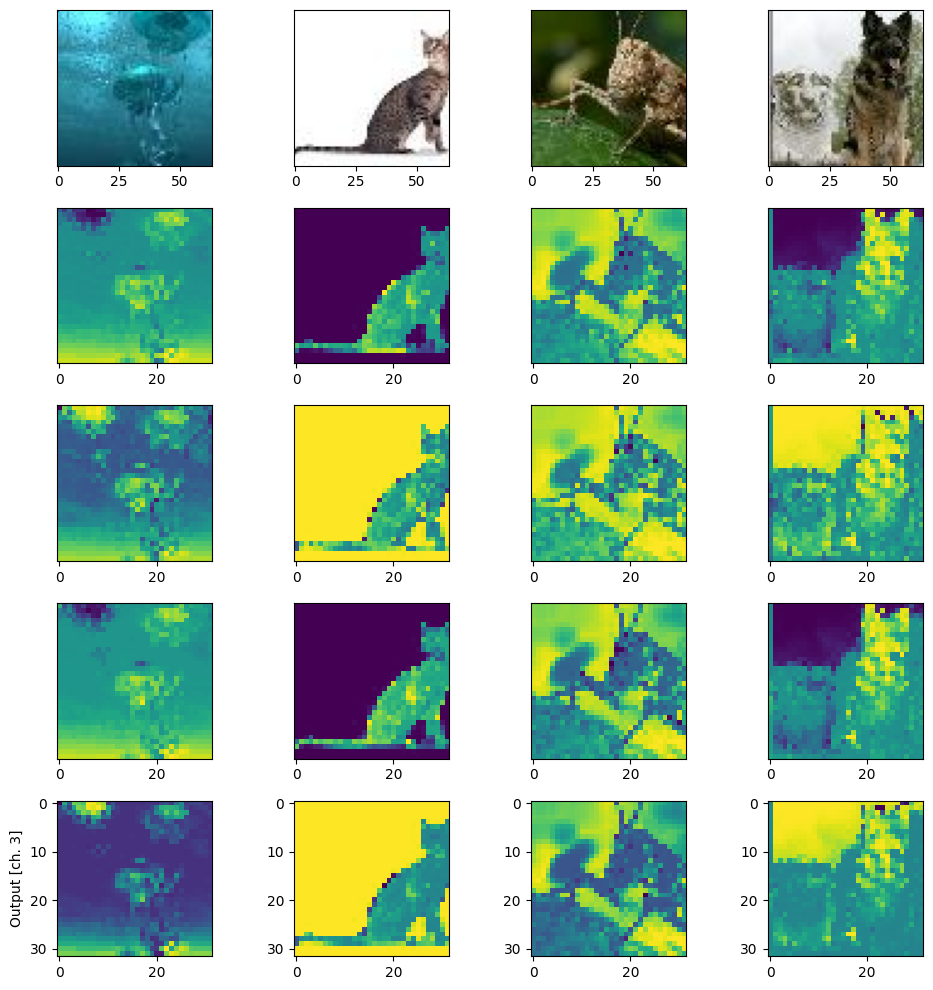

In [13]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for index, k in enumerate([class_0+1,class_1+1,class_2+1,class_3+1]):
    axes[0, 0].set_ylabel("Input")
    if index != 0:
        axes[0, index].yaxis.set_visible(False)
    print("Original shape:",x_original[k][ :, :].shape)
    axes[0, index].imshow(x_original[k])

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, index].yaxis.set_visible(False)
        quanvoluted = x_quanv[k][ :, :, c]
        print("Quanvoluted shape:",quanvoluted.shape)
        axes[c + 1, index].imshow(quanvoluted, cmap="viridis")

plt.tight_layout()
plt.show()

# Heatmap generated using GradCAM for Quanvolution

In [16]:
# Load saved qnn model
q_model = load_model("./Models/qnn-"+ encoding + "-" + ansatz + "-" + str(filter_size) +".h5")

In [18]:
print(q_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 400)            │       410,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        40,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 455,357 (1.74 MB)

 Trainable params: 455,354 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3 (16.00 B)

None


## QNN model metrics

In [229]:
predictions = [tf.argmax(pred).numpy() for pred in q_model.predict(tf.convert_to_tensor(x_quanv))]

print("Accuracy >> ", accuracy_score(y,predictions))
print("F1-Score >> ", f1_score(y,predictions, average='weighted'))
print("Precision >> ", precision_score(y,predictions, average='weighted'))
print("Recall >> ", recall_score(y,predictions, average='weighted'))

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
Accuracy >>  0.8714880332986472
F1-Score >>  0.8713808985636101
Precision >>  0.8716741672686941
Recall >>  0.8714880332986472


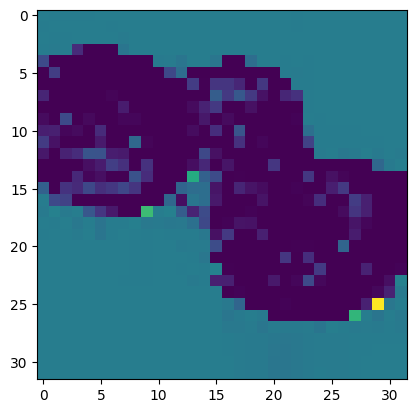

In [230]:
x = tf.convert_to_tensor([x_quanv[demo_index]])
heatmap_qnn = grad_cam(q_model, x, y[demo_index])
plt.imshow(heatmap_qnn)
plt.show()

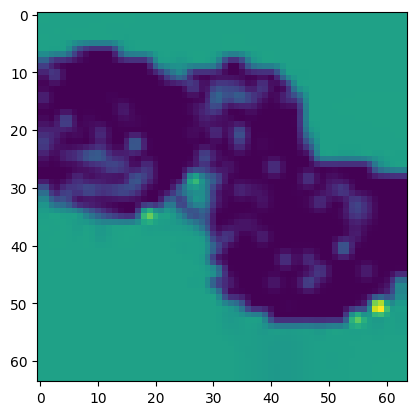

In [231]:
from skimage.transform import resize

# Resize and normalize (skimage automatically converts to float64 in [0,1])
heatmap_resized = resize(heatmap_qnn, (64,64), anti_aliasing=True)
plt.imshow(heatmap_resized)

# Explainability

In [232]:
calculate_explainability(heatmap_qnn = heatmap_qnn, heatmap_xcnn = heatmap_xcnn)

np.float64(20.162003529917232)

# Heatmaps to 3D

In [233]:
import matplotlib as mpl

def get_color_heatmap(heatmap):
    heatmap = np.uint8(255 * heatmap)
    jet = mpl.colormaps["jet"]
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = jet_heatmap[:,:,0,:3]
    jet_heatmap = jet_heatmap/255
    return jet_heatmap


(64, 64, 3) (64, 64, 3)


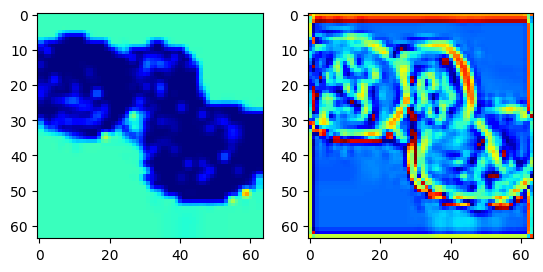

In [234]:
qnn_jet = get_color_heatmap(resize(heatmap_qnn, heatmap_xcnn.shape, anti_aliasing=True))
xcnn_jet = get_color_heatmap(heatmap_xcnn)

print(qnn_jet.shape, xcnn_jet.shape)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(qnn_jet*255)
axarr[1].imshow(xcnn_jet*255)